In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()

In [6]:
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [10]:
engine.execute("SELECT * FROM measurement LIMIT 5").fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0)]

In [11]:
inspector = inspect(engine)
print('Measurement columns')
meas_col = inspector.get_columns('measurement')
for c in meas_col:
    print(c['name'], c['type'])
    
print('\nStation columns')
stat_col = inspector.get_columns('station')
for c in stat_col:
    print(c['name'], c['type'])

Measurement columns
id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT

Station columns
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [12]:
engine.execute("SELECT * FROM station LIMIT 5").fetchall()

[(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 (3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0),
 (4, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9),
 (5, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6)]

# Exploratory Precipitation Analysis

In [13]:
# Find the most recent date in the data set.
recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]
recent_date

'2017-08-23'

Text(0.5, 0, 'Date')

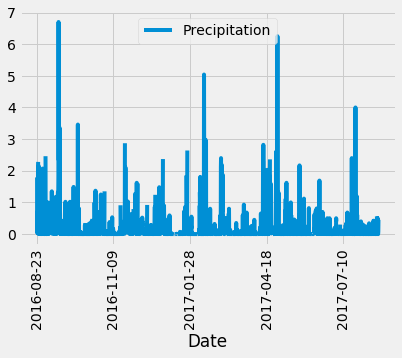

In [30]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
month_12 = dt.date(2017, 8, 23) - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
last_12 = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= month_12).all()


# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(last_12, columns = ['Date', 'Precipitation'])

# Sort the dataframe by date
df = df.sort_values("Date")
df.set_index("Date")

# dfsum = df.groupby('Date').sum()
# dfsum
df.plot(x='Date', y='Precipitation', rot=90)
plt.xlabel("Date")
# df.columns

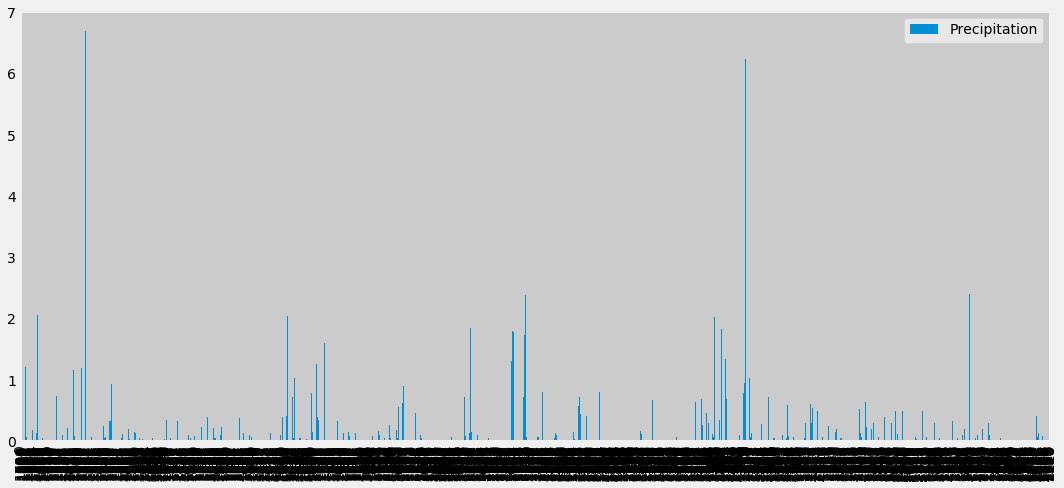

In [25]:
# Use Pandas Plotting with Matplotlib to plot the data
x = df.plot.bar(figsize=(15, 7))
#x.set_xticklabels ([w if not i%40 else "" for i, w in enumerate(x.get_xticklabels())])
#df.plot(kind="bar", use_index=True)
#dfscore.plot.bar()
plt.tight_layout()
plt.show()
#plot.show()



In [16]:
plt.show()

In [17]:
# Use Pandas to calcualte the summary statistics for the precipitation data
summary = df.describe()
summary

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [18]:
# Design a query to calculate the total number stations in the dataset
session.query(Station.station).count()

9

In [19]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
activate_stations = "SELECT station, COUNT(station) AS count \
FROM measurement \
GROUP BY station \
ORDER BY count DESC;"

engine.execute(activate_stations).fetchall()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [20]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active = f"SELECT min(tobs), max(tobs), avg(tobs) \
FROM measurement \
WHERE station = 'USC00519281';"
# sel_statement = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
# results = session.query(sel_statement)
most_active_results = engine.execute(most_active).fetchall()

print(f"Station: USC00519281 \n\
Lowest Temperature: {most_active_results[0][0]}\n\
Highest Temperature: {most_active_results[0][1]}\n\
Average Temperature: {round(most_active_results[0][2], 2)}")


Station: USC00519281 
Lowest Temperature: 54.0
Highest Temperature: 85.0
Average Temperature: 71.66


In [33]:
sel_statement = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
results = session.query(*sel_statement)
results.all()

[(53.0, 73.09795396419437, 87.0)]

In [21]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp_last_12 = session.query(Measurement.date, Measurement.tobs).\
filter(Measurement.date >= month_12).\
filter(Measurement.date <= recent_date).\
filter(Measurement.station == 'USC00519281').all()
temp_last_12

[('2016-08-23', 77.0),
 ('2016-08-24', 77.0),
 ('2016-08-25', 80.0),
 ('2016-08-26', 80.0),
 ('2016-08-27', 75.0),
 ('2016-08-28', 73.0),
 ('2016-08-29', 78.0),
 ('2016-08-30', 77.0),
 ('2016-08-31', 78.0),
 ('2016-09-01', 80.0),
 ('2016-09-02', 80.0),
 ('2016-09-03', 78.0),
 ('2016-09-04', 78.0),
 ('2016-09-05', 78.0),
 ('2016-09-06', 73.0),
 ('2016-09-07', 74.0),
 ('2016-09-08', 80.0),
 ('2016-09-09', 79.0),
 ('2016-09-10', 77.0),
 ('2016-09-11', 80.0),
 ('2016-09-12', 76.0),
 ('2016-09-13', 79.0),
 ('2016-09-14', 75.0),
 ('2016-09-15', 79.0),
 ('2016-09-16', 78.0),
 ('2016-09-17', 79.0),
 ('2016-09-18', 78.0),
 ('2016-09-19', 78.0),
 ('2016-09-20', 76.0),
 ('2016-09-21', 74.0),
 ('2016-09-22', 77.0),
 ('2016-09-23', 78.0),
 ('2016-09-24', 79.0),
 ('2016-09-25', 79.0),
 ('2016-09-26', 77.0),
 ('2016-09-27', 80.0),
 ('2016-09-28', 78.0),
 ('2016-09-29', 78.0),
 ('2016-09-30', 78.0),
 ('2016-10-01', 77.0),
 ('2016-10-02', 79.0),
 ('2016-10-03', 79.0),
 ('2016-10-04', 79.0),
 ('2016-10-

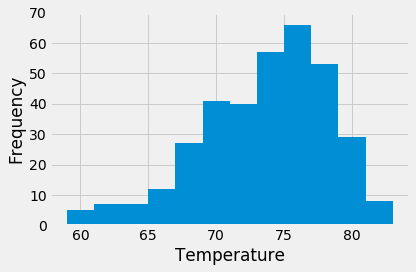

In [22]:
#Create DF for results
tempdf = pd.DataFrame(temp_last_12, columns=['Date', 'Temperature'])
tempdf.set_index('Date', inplace=True)
tempdf.plot.hist(bins=12, ylim = (0,70), legend=False)
plt.xlabel("Temperature")
plt.tight_layout()
plt.show()

# Close session

In [23]:
# Close Session
session.close()